<a href="https://colab.research.google.com/github/gcarleo/cecam-ml-2025/blob/main/2/gs-heisenberg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ground-State: Heisenberg model

Author: Giuseppe Carleo and Filippo Vicentini (EPFL-CQSL)

The goal of this tutorial is to review various neural network architectures available in NetKet, in order to learn the ground-state of a paradigmatic spin model: the spin-$1/2$ Heisenberg antiferromagnetic chain.

The Hamiltonian we will consider for this tutorial is the following

$$ H = \sum_{i=1}^{L} \vec{\sigma}_{i} \cdot \vec{\sigma}_{i+1}.$$

$L$ is the length of the chain, and we will use both open and periodic boundary conditions. $\vec{\sigma}=(\sigma^x,\sigma^y,\sigma^z)$ denotes  the vector of Pauli matrices. Please note that there is a factor of $2$ between Pauli-matrices and spin-1/2 operators (thus a factor of $4$ in $H$).

We will consider in this tutorial 5 possible ways of determining the ground-state of this model.

## 0. Installing Netket

If you are executing this notebook on Colab, you will need to install netket. You can do so by running the following cell:

In [33]:
%pip install --quiet netket

We also want make to sure that this notebook is running on the cpu.
You can edit the field by changing "cpu" to "gpu" to make it run on the GPU if you want.
But you'll need to use much larger systems to see a benefit in the runtime.
For systems with less than 40 spins GPUs slow you down remarkably.

In [34]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

*After* having defined this environment variable, we can load netket and the various libraries that we will be using throughout the tutorial.

In [35]:
# Import netket library
import netket as nk

# Import Json, this will be needed to load log files
import json

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

## 1. Defining the Hamiltonian

NetKet covers quite a few standard Hamiltonians and lattices, so let's use this to quickly define the antiferromagnetic Heisenberg chain.
For the moment we assume $L=22$ and simply define a chain lattice in this way (using periodic boundary conditions for now).

In [36]:
# Define a 1d chain
L = 22
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

Next, we need to define the Hilbert space on this graph.
We have here spin-half degrees of freedom, and as we know that the ground-state sits in the zero magnetization sector, we can already impose this as a constraint in the Hilbert space.
This is not mandatory, but will nicely speeds things up in the following.

In [37]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero
hi = nk.hilbert.Spin(s=0.5, total_sz=0, N=g.n_nodes)

The final element of the triptych is of course the Hamiltonian acting in this Hilbert space, which in our case in already defined in NetKet.
Note that the NetKet Hamiltonian uses Pauli Matrices (if you prefer to work with spin-$1/2$ operators, it's pretty trivial to define your own custom Hamiltonian, as covered in another tutorial)

In [38]:
# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)

## 2. Exact Diagonalization (as a testbed)

Just as a matter of future comparison, let's compute the exact ground-state energy (since this is still possible for $L=22$ using brute-force exact diagonalization).
NetKet provides wrappers to the Lanczos algorithm which we now use:

In [ ]:
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)

# Just in case you can't do this calculation, here is the result
# exact_gs_energy = -39.14752260706246

## 3. The Jastrow ansatz

Let's start with a simple ansatz for the ground-state: the Jastrow Ansatz.

$ \log\psi(\sigma) = \sum_i a_i \sigma_i + \sum_{i,j} \sigma_i J_{i,j} \sigma_j $

To show how it's done, we write this simple ansatz as a `flax.nnx` module.
We import this module and call it `nnx`, as it is customary in the Flax documentation.

An NNX model subclasses `nnx.Module` and defines its parameters inside `__init__` using `nnx.Param`.

As the module should work with batches of inputs (therefore the input will be a 2d matrix with shape `(N_inputs, N_sites)`, but we are lazy and find it easier to define the function for a single input $\sigma$, a 1D vector of shape `(N_sites,)`.
Therefore, we write a function called `evaluate_single`, which will evaluate a single 1D input, and use `jax.vmap` to make it work with 2D inputs as well.

To learn more about jax.vmap, give a look at the jax documentation!

In [ ]:
from flax import nnx
import jax.numpy as jnp
import jax

class Jastrow(nnx.Module):
    def __init__(self, N: int, *, rngs: nnx.Rngs):
        k1, k2 = jax.random.split(rngs.params())
        self.J = nnx.Param(0.01 * jax.random.normal(k1, (N, N),
                                                    dtype=jnp.complex128))

        self.v_bias = nnx.Param(0.01 * jax.random.normal(k2, (N, 1),
                                                         dtype=jnp.complex128))

    def __call__(self, x):
        x = x.astype(jnp.complex128)              # keep the dtypes aligned
        quad = jnp.einsum('...i,ij,...j->...', x, self.J, x)
        lin  = jnp.squeeze(x @ self.v_bias, -1)   # (...,N) @ (N,1) → (...,1)
        return quad + lin

Now that the model is defined, we can instantiate it

In [ ]:
ma = Jastrow(N=hi.size, rngs=nnx.Rngs(0))
print(ma)

In [ ]:
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=False)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1008)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(300, out='Jastrow')
end = time.time()

print('### Jastrow calculation')
print('Has',nk.jax.tree_size(vs.parameters),'parameters')
print('The Jastrow calculation took',end-start,'seconds')

In [ ]:
# import the data from log file
data_Jastrow=json.load(open("Jastrow.log"))

iters_Jastrow = data_Jastrow["Energy"]["iters"]
energy_Jastrow = data_Jastrow["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_Jastrow[-1],exact_gs_energy-0.1,exact_gs_energy+0.4])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_Jastrow[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

Well that's not too bad for a simple ansatz. But we can do better, can't we?

## 3. Learning with a Restricted Boltzmann Machine (RBM)

We will now consider another celebrated ansatz, the Restricted Boltzmann Machine (RBM). It simply consists of two layers: a visible one representing the $L$ spin 1/2 degrees of freedom, and an hidden one which contains a different number $M$ of hidden units. There are connections between all visible and hidden nodes. The ansatz is the [following](https://www.netket.org/docs/machine_RbmSpin/)

$\Psi_{\rm RBM} (\sigma_1^z,\sigma_2^z, ..., \sigma_L^z)  = \exp ( \sum_{i=1}^L a_i \sigma_i^z ) \prod_{i=1}^M \cosh (b_i + \sum_j W_{ij} \sigma^z_j)$

$a_i$ (resp. $b_i$) are the visible (resp. hidden) bias. Together with the weights $W_{ij}$, they are variational parameters that we (or rather NetKet) will optimize to minimize the energy. Netket gives you the control on the important parameters in this ansatz, such as $M$ and the fact that you want to use or not the biases. The full explanation is [here](https://www.netket.org/docs/machine_RbmSpin/).

More conveniently (especially if you want to try another $L$ in this tutorial), let's define the hidden unit density $\alpha = M / L$, and invoke the RBM ansatz in NetKet with as many hidden as visible units.

In [ ]:
# RBM ansatz with alpha=1
ma = nk.models.RBM(alpha=1)

And let us use the same sampler (Metropolis exchange) with some different random initial parameters, optimizer (stochastic gradient), and variational method (stochastic reconfiguration) as for the Jastrow ansatz, and let's run things!

In [ ]:
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1008)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBM', n_iter=600)
end = time.time()

print('### RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The RBM calculation took',end-start,'seconds')

In [ ]:
# import the data from log file
data=json.load(open("RBM.log"))

# Extract the relevant information
iters_RBM = data["Energy"]["iters"]
energy_RBM = data["Energy"]["Mean"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.plot(iters_RBM, energy_RBM, color='red', label='Energy (RBM)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_RBM[-1],exact_gs_energy-0.03,exact_gs_energy+0.2])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

Note that this plot zooms closer to the exact ground-state energy. With 600 iterations, we start to see convergence and reach the ground-state energy within about one per thousand, this is already nice! But we are not totally there yet, and in particular the simpler (less parameters) Jastrow wave-function seems to perform better for this example. How can we improve things? As an exercise, try to increase the number of hidden units and/or the number of iterations. What is happening? You can also check out the influence of the learning rate.

By playing with these parameters, you have hopefully arrived at an improved result, but likely at an increased CPU time cost. Let's do things differently, and take to our advantage the symmetries of the Hamiltonian in the neural network construction.


## 4. RBM again, this time with lattice symmetries

Let's define a similar RBM machine, which takes into account that the model has translational symmetries. All sites are equivalent and thus many of the wave-functions coefficients are related by symmetry. We use the same exact hyperparameters as in the previous RBM calculation ($\alpha=1$, same learning rate, and number of samples and iterations in the Variational Monte Carlo) and run now a symmetric RBM.

In [ ]:
## Symmetric RBM Spin Machine
ma = nk.models.RBMSymm(symmetries=g.translation_group(), alpha=1)

# Metropolis Exchange Sampling
# Notice that this sampler exchanges two neighboring sites
# thus preservers the total magnetization
sa = nk.sampler.MetropolisExchange(hi, graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1008)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBMSymmetric', n_iter=300)
end = time.time()

print('### Symmetric RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The Symmetric RBM calculation took',end-start,'seconds')

The simulation was much faster, wasn't it? There were of course much less parameters to optimize. Now let's extract the results and plot them using a zoomed scale, and together with the previous results with the RBM.

In [ ]:
## import the data from log file
data=json.load(open("RBMSymmetric.log"))

# Extract the relevant information
iters_symRBM = data["Energy"]["iters"]
energy_symRBM = data["Energy"]["Mean"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.plot(iters_RBM, energy_RBM, color='red', label='Energy (RBM)')
ax1.plot(iters_symRBM, energy_symRBM, color='blue', label='Energy (Symmetric RBM)')

ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
if exact_gs_energy:
    plt.axis([0,iters_symRBM[-1],exact_gs_energy-0.06,exact_gs_energy+0.12])
    plt.axhline(y=exact_gs_energy, xmin=0,
                    xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

Not only the simulation was faster in terms of CPU time, but we are now reaching the ground-state in a much lower number of iterations! Imposing symmetries greatly helps, and NetKet allows to do this. Note that there is also a symmetric version of the Jastrow ansatz that we tested earlier in NetKet, which is called `JastrowSymm`. As an exercise, check it out. What you will find is that while it converges slightly faster in terms of iterations with respect to the non-symmetric Jastrow, it does not improve the estimate of the ground-state energy. We actually see that the symmetric RBM sets the standard very high.

## 5. Learning with Feed Forward Neural Networks

Now let's try a more complex network, namely a Feed Forward Neural Network (FFNN). There you will have more freedom to construct your own specific architecture. We'll try two different FFNN in this tutorial.

The first one is a simple structure: the first layer takes as input L-dimensional input, applies a bias and outputs two times more data, just followed by a `Lncosh` activation layer. The final layer `SumOutput` is needed to obtain a single number for the wave-function coefficient associated to the input basis state.


In [29]:
class Model(nnx.Module):

    def __init__(self, N: int, *, rngs: nnx.Rngs):
        self.linear = nnx.Linear(in_features=N, out_features=2 * N, dtype=jnp.complex128, rngs=rngs)

    def __call__(self, x: jax.Array):
        x = self.linear(x)
        x = nk.nn.activation.log_cosh(x)
        return jnp.sum(x, axis=-1)

ffnn = Model(N=hi.size, rngs=nnx.Rngs(1))

sa = nk.sampler.MetropolisExchange(hi, graph=g)

# The variational state
vs = nk.vqs.MCState(sa, ffnn, n_samples=1008)

opt = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=False)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)


start = time.time()
gs.run(out='FF', n_iter=300)
end = time.time()

print('### Feed Forward calculation')
print('Has',vs.n_parameters,'parameters')
print('The Feed Forward calculation took',end-start,'seconds')


  0%|          | 0/300 [00:00<?, ?it/s]

### Feed Forward calculation
Has 1012 parameters
The Feed Forward calculation took 160.78827500343323 seconds


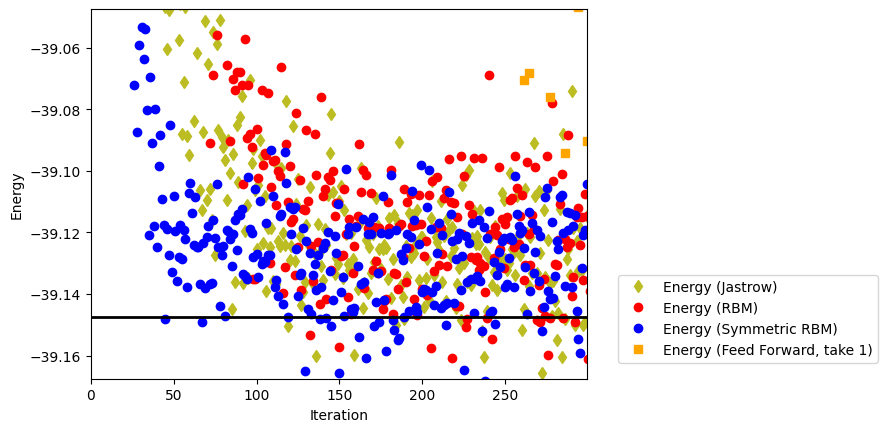

In [30]:
# import the data from log file
data=json.load(open("FF.log"))

# Extract the relevant information
iters_FF = data["Energy"]["iters"]
energy_FF = data["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8',linestyle="None", marker='d',label='Energy (Jastrow)')
ax1.plot(iters_RBM, energy_RBM, color='red', marker='o',linestyle="None",label='Energy (RBM)')
ax1.plot(iters_symRBM, energy_symRBM, color='blue',linestyle="None",marker='o',label='Energy (Symmetric RBM)')
ax1.plot(iters_FF, energy_FF, color='orange', marker='s',linestyle="None",label='Energy (Feed Forward, take 1)')
ax1.legend(bbox_to_anchor=(1.05, 0.3))
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_FF[-1],exact_gs_energy-0.02,exact_gs_energy+0.1])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
plt.show()

The results are clearly better than a simple (non-symmetrized RBB), and perform slightly better than the Jastrow ansatz. Let us increase the number of layers by adding a fully-connected layer with bias and  `Lncosh` activation (with $2L$ inputs and outputs) before the final `SumOutput` layer.

In [31]:
class Model2(nnx.Module):

    def __init__(self, N: int, *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(in_features=N, out_features=2 * N, dtype=jnp.complex128, rngs=rngs)
        self.linear2 = nnx.Linear(in_features=2 * N, out_features=N, dtype=jnp.complex128, rngs=rngs)

    def __call__(self, x: jax.Array):
        x = self.linear1(x)
        x = nk.nn.activation.log_cosh(x)
        x = self.linear2(x)
        x = nk.nn.activation.log_cosh(x)
        return jnp.sum(x, axis=-1)

ffnn2 = Model2(N=hi.size, rngs=nnx.Rngs(1))

# The variational state
vs = nk.vqs.MCState(sa, ffnn, n_samples=1008)

opt = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=False)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)


start = time.time()
gs.run(out='FF2', n_iter=600)
end = time.time()


print('### Feed Forward (more layers) calculation')
print('Has',vs.n_parameters,'parameters')
print('The Feed Forward (more layers) calculation took',end-start,'seconds')


  0%|          | 0/600 [00:00<?, ?it/s]

### Feed Forward (more layers) calculation
Has 1012 parameters
The Feed Forward (more layers) calculation took 322.0901691913605 seconds


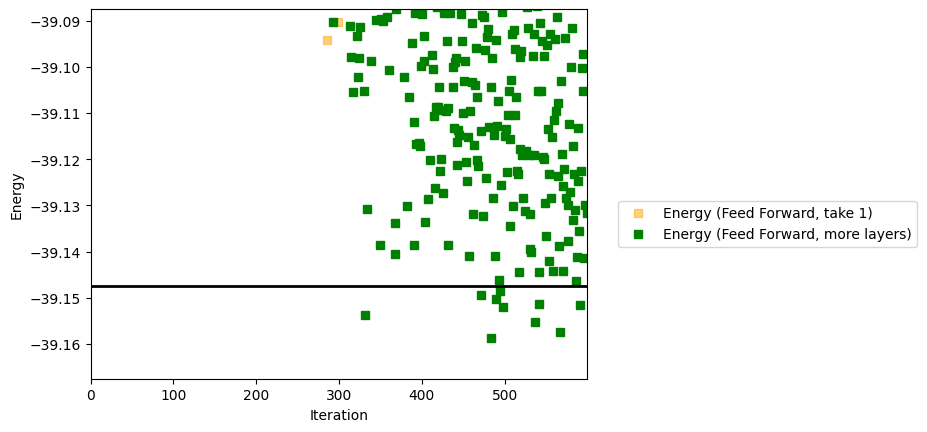

In [32]:
# import the data from log file
data=json.load(open("FF2.log"))

# Extract the relevant information
iters_FF_morelayers = data["Energy"]["iters"]
energy_FF_morelayers = data["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
#ax1.plot(iters_Jastrow, energy_Jastrow, color='C8',linestyle="None", marker='d',label='Energy (Jastrow)')
#ax1.plot(iters_RBM, energy_RBM, color='red', label='Energy (RBM)')
#ax1.plot(iters_symRBM, energy_symRBM, color='blue',linestyle="None",marker='o',label='Energy (Symmetric RBM)')
ax1.plot(iters_FF, energy_FF, color='orange', marker='s',alpha=0.5,linestyle="None",label='Energy (Feed Forward, take 1)')
ax1.plot(iters_FF_morelayers, energy_FF_morelayers, color='green',marker='s',linestyle="None", alpha=1,label='Energy (Feed Forward, more layers)')
ax1.legend(bbox_to_anchor=(1.05, 0.5))
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_RBM[-1],exact_gs_energy-0.02,exact_gs_energy+0.06])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
plt.show()

The results are even better, but at the price of an increase in computational time....

Note that more complex structures, such as Convolutional Neural Networks (CNN), can also be used within Netket. However, for such 1d systems, they do not bring too much compared to the symmetric RBM (as a matter of fact, the symmetric RBM is a special type of a simple CNN. CNNs show their full strength for more complex systems, such as 2d quantum systems. Convolutional Neural Networks will be the topic of another tutorial in NetKet (and we'll make there the connection with the special case of the symmetric RBM).

Finally let us conclude that another type of machine, Matrix Product States (MPS), is also available in NetKet. They do perform extremely well for 1d quantum systems. Since however they are a bit different, they will be presented in another tutorial.